# Icosphere example models

*(GE Tucker, CU Boulder, November 2023)*

This notebook illustrates some examples of simple models that use the Landlab `IcosphereGlobalGrid` class.

We'll start with some imports:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import landlab.io.legacy_vtk as vtk
from landlab import IcosphereGlobalGrid

## Example 1: radiative energy balance for a planet

Consider a rocky planet that is heated by radiation from its star, and radiates energy into space. Imagine there's a "thermally active crust" layer of thickness $H$. A patch of crust of surface area $A$ receives energy from solar radiation, and loses energy by longwave radiation. Its thermal energy per unit mass is $E$. The change in temperature, $dT$, corresponding to a change in thermal energy, $dE$, is given by

$$dT = \frac{1}{m C_p} dE$$

where $m$ (kg) is mass and $C_p$ (J/kg K) is specific heat.

Energy balance dictates that

$$\frac{\partial E A H}{\partial t} = A S - A L$$

where $S$ is incoming (shortwave) radiant energy in W/m$^2$ and $L$ is outgoing (longwave) radiant energy in the same units.

This leads to:

$$\frac{\partial T}{\partial t} = \frac{1}{\rho C_p H}(S - L)$$

The radiant influx depends on latitude, $\theta$, and the axis tilt $\psi$ toward the sun (which varies throughout the year of course, creating seasons):

$$S = S_0 (1 - a) \max (\cos(\theta + \psi), 0)$$

where $S_0$ is solar irradiance and $a$ is albedo.

The outflux depends on temperature via the Stefan-Bolzmann law (assuming our planet is effectively a blackbody in the infrared):

$$L = \sigma T^4$$

So our complete equation is:

$$\frac{\partial T}{\partial t} = \frac{1}{\rho C_p H} 
\left( S_0 (1 - a) \max (\cos(\theta + \psi), 0) - \sigma T^4\right)$$



In [ ]:
# Parameters
radius = 6.37e6  # planetary radius, m
sec_per_year = 3600 * 24 * 365.25
S0 = 1360.0  # incoming shortwave, W/m2
a = 0.3  # albedo
sigma = 5.67e-8  # Stefan-Boltzmann constant
rho = 3000.0  # density, kg/m3
Cp = 1000.0  # specific heat, J/kg K
H = 10000.0  # crust thickness, m
max_tilt_deg = 23.5  # maximum seasonal tilt, degrees
dt = sec_per_year / 18.0  # time step duration, s
run_duration = 2500.0 * sec_per_year  # duration of run, s

# Other setup
max_tilt = np.radians(max_tilt_deg)  # convert to radians
coef = 1.0 / (rho * Cp * H)  # lump coefficients
shortwave_eq = (1.0 / np.pi) * S0 * (1 - a)  # shortwave at equator

# Data structures
mean_temp = []  # list to accumulate mean temperature over time
mean_lw = []  # list to accumulate mean longwave over time

In [ ]:
# Instantiate an IcosphereGlobalGrid
grid = IcosphereGlobalGrid(radius=radius, mesh_densification_level=4)

# Set up some array data
lat = np.pi / 2 - grid.theta_of_node  # latitude in radians
temp = np.zeros(grid.number_of_cells)  # field for temperature
temp[:] = 3.0  # starting temperature, K

In [ ]:
# Main loop
current_time = 0.0
while current_time < run_duration:
    # update tilt for the current time of year
    tilt = max_tilt * np.sin(2 * np.pi * current_time / sec_per_year)

    # calculate incoming shortwave at each grid cell
    shortwave = shortwave_eq * np.maximum(np.cos(lat + tilt), 0.0)

    # calculate outgoing longwave at each grid cell
    longwave = sigma * temp**4

    # calculate rate of change of temperature at each grid cell
    dTdt = coef * (shortwave - longwave)

    # update the temperature field
    temp += dTdt * dt

    # update time
    current_time += dt

    # record the mean temperature and longwave
    mean_temp.append(np.mean(temp))
    mean_lw.append(np.mean(longwave))

In [ ]:
# plot the global mean temperature over time
plt.plot(
    np.linspace(dt / sec_per_year, run_duration / sec_per_year, len(mean_temp)),
    mean_temp,
)
plt.xlabel("Time (years)")
plt.ylabel("Global mean temperature (K)")

In [ ]:
# plot the temperature by latitude
plt.plot(180.0 * lat / np.pi, temp, ".")
plt.xlabel("Latitude (degrees)")
plt.ylabel("Temperature (K)")

In [ ]:
# for output, assign temperature to patches by averaging over eac
# triangular patches 3 nodes
temp_at_patch = np.mean(temp[grid.nodes_at_patch], axis=1)

In [ ]:
# output data to a legacy-VTK format file
grid.at_patch["surface_temperature"] = temp_at_patch
grid.at_cell["surface_temperature"] = temp

with open("radiative_energy_bal-patches.vtk", "w") as fp:
    vtk.dump(grid, fp, include="*temperature", at="node")

with open("radiative_energy_bal-cells.vtk", "w") as fp:
    vtk.dump(grid, fp, include="*temperature", at="corner")

The image below is from a ParaView rendering of the final surface temperature, looking down from above the north pole:

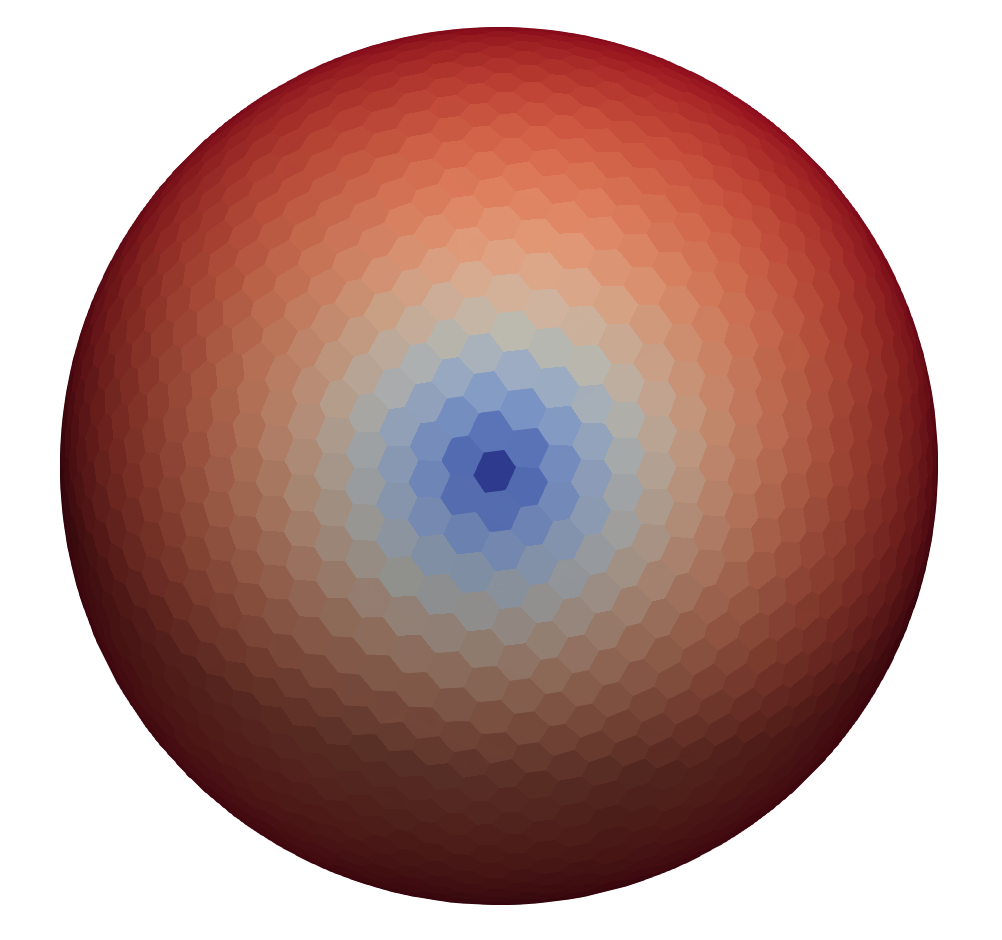

In [ ]:
# compare temperature predicted by a simple energy balance with the
# numerical model calculation - they should differ a bit because the
# numerical model is spatially distributed
energy_bal_est = (S0 * (1 - a) / (4 * sigma)) ** 0.25 - 273.15
model_mean_temp = np.sum(grid.area_of_cell * temp) / (4 * np.pi * radius**2) - 273.15
print("Energy balance predicted mean temperature (C):", energy_bal_est)
print("Numerical model mean temperature (C)", model_mean_temp)

Part of the difference reflects transience: the numerical model might not have quite reached steady state. But is that all, or is it a result of the nonlinearity in the Stefan-Boltzmann law?

## Example 2: lateral heat diffusion in the crust of an asteroid

Suppose we have a small asteroid with a crust that is thermally insulated, exchanging essentially no heat with its interior (and receiving too little from the distant sun to make much difference). Why would we consider such a odd thing? Only to provide a test simple case: we want to see if we can use the `IcosphereGlobalGrid` to model heat diffusion in such a situation, using the Landlab functions `calc_grad_at_link` and `calc_flux_div_at_node`. We'll imagine further that the crust is initially relatively chilly, 250 K, but a meteorite impact has just flash-heated the crust at one location to 850 K. We want to demonstrate that the heat initially at the south pole will diffuse to adjacent latitudes. We also want to demonstrate that the total heat content, as represented by the area-averaged temperature, remains constant.

This case also provides an example of how to output a series of files that are numbered consecutively, so they can be imported into ParaView to create an animation.

In [ ]:
# Create a grid to represent the surface of an asteroid
radius = 500.0
grid = IcosphereGlobalGrid(radius=radius, mesh_densification_level=4)

# Set one grid cell to a high temperature, and all the others to a much lower temperature
temp = np.zeros(grid.number_of_nodes) + 250.0
temp[28] = 850.0

# Create an array for heat flux between cells (on links)
heat_flux = np.zeros(grid.number_of_links)

In [ ]:
# Parameters
D = 1.0e-6  # diffusion coefficient (m2/s)
nsteps = 101  # number of steps
output_interval = 5  # interval for output
dt = 0.5 * sec_per_year

In [ ]:
# Setup
surface_area = 4.0 * np.pi * radius**2
area_weighted_mean_temp = np.zeros(nsteps + 1)
area_weighted_mean_temp[0] = np.sum(grid.area_of_cell * temp) / surface_area
max_temp = np.zeros(nsteps + 1)
max_temp[0] = np.amax(temp)
time_slice_number = 0

# Output the initial state
grid.at_patch["surface_temperature"] = temp_at_patch
grid.at_cell["surface_temperature"] = temp

with open("diffusion_on_a_sphere000-patches.vtk", "w") as fp:
    vtk.dump(grid, fp, include="*temperature", at="node")

with open("diffusion_on_a_sphere000-cells.vtk", "w") as fp:
    vtk.dump(grid, fp, include="*temperature", at="corner")

In [ ]:
# Main loop
for i in range(nsteps):
    # Calculate temperature gradients along links
    dTdx = grid.calc_grad_at_link(temp)

    # Update heat fluxes
    heat_flux[:] = -D * dTdx

    # Calculate divergence of flux
    dqdx = grid.calc_flux_div_at_node(heat_flux)

    # Update the temperature for one time step
    temp -= dqdx * dt

    # Update mean and maximum temperature
    area_weighted_mean_temp[i + 1] = np.sum(grid.area_of_cell * temp) / surface_area
    max_temp[i + 1] = np.amax(temp)

    # Write output once in a while
    if (i + 1) % output_interval == 0:
        time_slice_number += 1

        with open(f"diffusion_on_a_sphere{time_slice_number:03d}-cells.vtk", "w") as fp:
            vtk.dump(grid, fp, include="*temperature", at="corner")

In [ ]:
# Plot final temperature as a function of latitude
plt.scatter(90 - grid.theta_of_node * 180 / np.pi, temp)
plt.xlabel("Latitude (degrees)")
plt.ylabel("Temperature (K)")

In [ ]:
# Plot mean temperature over time: if energy is properly conserved,
# this should be constant
plt.figure()
t = np.linspace(0, dt / sec_per_year * nsteps, len(area_weighted_mean_temp))
plt.plot(
    t,
    area_weighted_mean_temp,
    label="Average",
)
plt.plot(t, max_temp, "r", label="Maximum")
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Temperature (K)")

Conclusion: numerical routines like `calc_grad_at_link` and `calc_flux_div_at_node` work just fine on an `IcoshereGlobalGrid`.

If we list the output files, we see two sequences of `vtk`-format files: one for cells and corners, and one for patches and nodes. Both will be recogized by ParaView as a collection, and can be played as an animation.

In [ ]:
!ls diffusion_on*cells.vtk
!ls diffusion_on*patches.vtk

Conclusion: you can generate sequences of output files that ParaView (and perhaps other packages) will recognize as such.

## Example 3: flow routing on global topography

The final example demonstrates flow routing applied to a global grid. Here the elevation values have been previously interpolated onto a level-5 icosphere grid from the ETOPO2022 digital elevation model. Nodes below sea level are tagged as boundary nodes, so that the `FlowAccumulator` component recognizes them as outlets. (Note that the `DepressionFinderAndRouter` depression handler is robust but does not scale well; it works on this relatively small example, but more performant choices would be better for larger datasets.)

In [ ]:
from landlab.components import FlowAccumulator

In [ ]:
# instantiate grid
grid = IcosphereGlobalGrid(radius=6.371e6, mesh_densification_level=5)

# read in data for topographic elevation
topo = grid.add_zeros("topographic__elevation", at="node")
topo[:] = np.loadtxt("global_elevation_etopo_ico_level5.txt")

# set ocean nodes to be boundaries for the flow accumulator
grid.status_at_node[topo < 0.0] = grid.BC_NODE_IS_FIXED_VALUE

In [ ]:
# instantiate and run the FlowAccumulator
fa = FlowAccumulator(grid, depression_finder="DepressionFinderAndRouter")
fa.run_one_step()

To demonstrate the functionality, here we draw a map of the computed drainage in South America. The drainage map is rather crude, reflecting the coarse resolution, but captures the major drainages, including the Amazon and Parana.

In [ ]:
def is_in_south_america(x0, y0):
    return x0 > 100 and x0 < 150 and y0 < 5 and y0 > -50


fig, ax = plt.subplots()

area = grid.at_node["drainage_area"]
rcvr = grid.at_node["flow__receiver_node"]

for i in range(grid.number_of_nodes):
    x0 = np.degrees(grid.phi_of_node[i])
    y0 = 90 - np.degrees(grid.theta_of_node[i])
    if area[i] >= 8.0e10 and is_in_south_america(x0, y0):
        x1 = np.degrees(grid.phi_of_node[rcvr[i]])
        y1 = 90 - np.degrees(grid.theta_of_node[rcvr[i]])
        ax.plot([x0, x1], [y0, y1], "k")
        ax.axis("equal")
        ax.set_xlabel("Longitude (degrees)")
        ax.set_ylabel("Latitude (degrees)")
        ax.set_title("South American drainages\n (level-5 resolution)")